浸水確率ラスターデータから点郡データを生成。パラメータ調整可能。（必要手続き：Driveの接続）

In [1]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title パラメータの設定
casename = "kurume-r2"

threshold = 0.1

num_pt_px = 7 # number of points randomly generated at every pixel

In [3]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_case = path_home + casename + "/"
file_prb = path_case + "floodprb.pt"
file_flbbox = path_case + "floodprb_bbox.npy"
file_pts = path_case + "flood_points.pkl"

In [4]:
# @title 主要ライブラリインポート
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

In [5]:
# @title 読み込み
output = torch.load(file_prb)
boundbox = np.load(file_flbbox)
print(boundbox)

[130.40000697  33.22445068 130.59998291  33.34999988]


(33.31, 33.36)

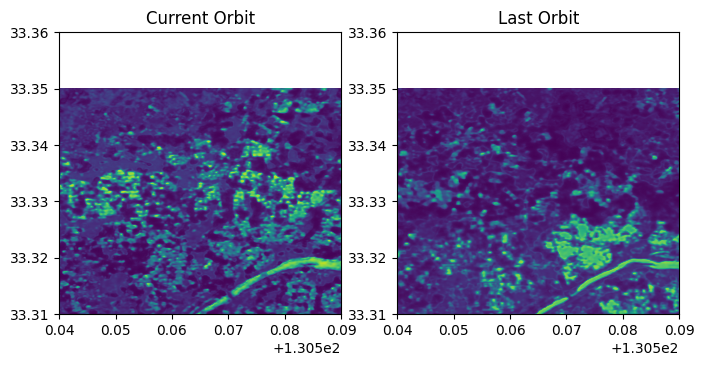

In [6]:
extent = [boundbox[0], boundbox[2], boundbox[1], boundbox[3]]
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[0, 1], extent=extent)
plt.title("Current Orbit")
plt.xlim([130.54, 130.59])
plt.ylim([33.31, 33.36])
plt.subplot(122)
plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[1, 1], extent=extent)
plt.title("Last Orbit")
plt.xlim([130.54, 130.59])
plt.ylim([33.31, 33.36])

(33.31, 33.36)

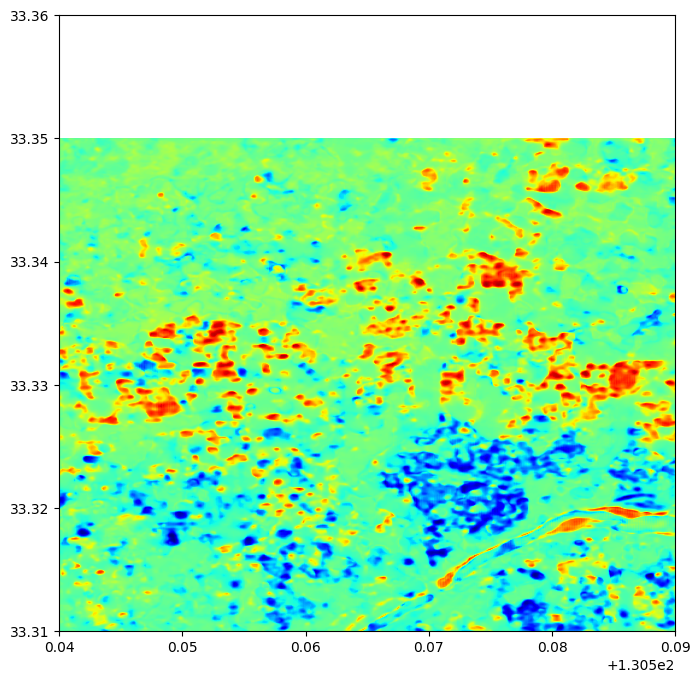

In [7]:
p_diff = torch.nn.functional.softmax(output, dim=1).numpy()[0, 1] - torch.nn.functional.softmax(output, dim=1).numpy()[1, 1]

plt.figure(figsize=(8, 8))
plt.imshow(p_diff, cmap='jet', extent=extent)
plt.xlim([130.54, 130.59])
plt.ylim([33.31, 33.36])


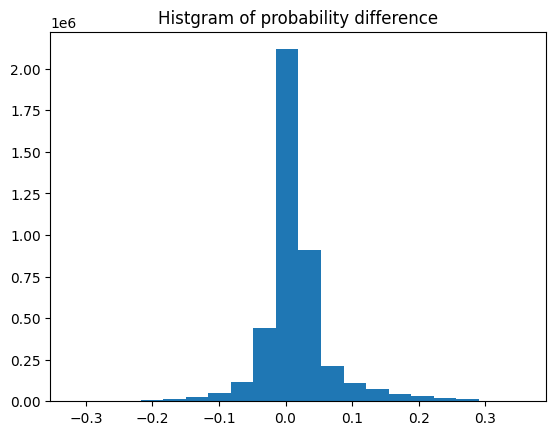

In [8]:
plt.hist(p_diff.ravel(), bins=20);
plt.title("Histgram of probability difference");

Text(0.5, 1.0, 'vv input, flood area ratio: 5.97%')

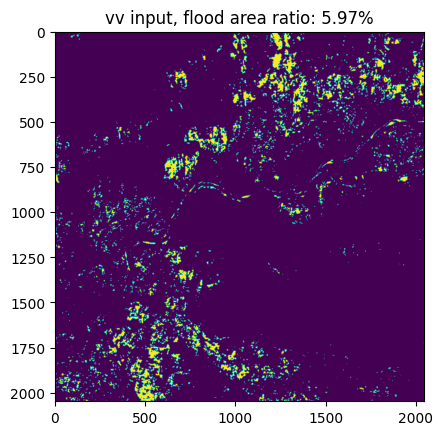

In [9]:
plt.imshow(p_diff > threshold)
plt.title(f"vv input, flood area ratio: {(100 * (p_diff > threshold).sum() / p_diff.ravel().shape).item():1.2f}%")

In [10]:
# shapeはタイルの形
def get_lonslats_from_boundbox(boundbox,shape):
  lon_min, lat_min, lon_max, lat_max = boundbox
  lons = np.linspace(lon_min,lon_max,shape[1],endpoint=False)
  lats = np.linspace(lat_min,lat_max,shape[0]+1,endpoint=True)[1:][::-1]
  return lons, lats

def reduce_specles(arr, patchsize = 3, specle_threshold=0.1):
  num_threshold = int(specle_threshold * patchsize**2)
  dd = int(patchsize/2)
  nx, ny = arr.shape
  sum = np.zeros_like(arr)
  for ii in np.arange(-dd,dd+1):
    for jj in np.arange(-dd,dd+1):
      sum[dd:-dd,dd:-dd] += arr[dd+ii:nx-dd+ii, dd+jj:ny-dd+jj]
  msk = np.array(sum <= num_threshold, dtype=int) * arr
  return arr - msk

def latlon_to_gridIdx(lat,lon,lats,lons,shape):
  cx = int(np.round((lon-lons[0])/(lons[-1]-lons[0])*shape[1]))
  cy = int(np.round((lat-lats[0])/(lats[-1]-lats[0])*shape[0]))
  return (cx, cy)

def gridIdx_to_lonlat(idx_x,idx_y,lons,lats):
  xx = int(idx_x)
  yy = int(idx_y)
  dx = idx_x - xx
  dy = idx_y - yy
  lon = (1-dx)*lons[xx] + dx * lons[xx+1]
  lat = (1-dy)*lats[yy] + dy * lats[yy+1]
  return (lon, lat)


In [11]:
print(p_diff.shape)
print(boundbox)
lons, lats = get_lonslats_from_boundbox(boundbox, p_diff.shape)
print(lons, len(lons))
print(lats, len(lats))
floodmap = np.array(p_diff > threshold, dtype=int)
print(floodmap)
print(np.max(floodmap))
totalsize = p_diff.ravel().shape[0]
print(totalsize)

(2048, 2048)
[130.40000697  33.22445068 130.59998291  33.34999988]
[130.40000697 130.40010462 130.40020226 ... 130.59968997 130.59978762
 130.59988526] 2048
[33.34999988 33.34993858 33.34987727 ... 33.22463459 33.22457329
 33.22451199] 2048
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
4194304


In [12]:
print(floodmap[1:-1,1:-1].shape)

(2046, 2046)


Text(0.5, 1.0, 'flood area ratio: 5.97%')

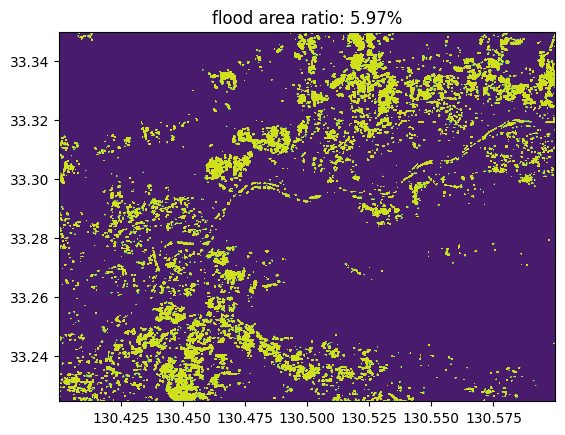

In [13]:
plt.contourf(lons,lats,floodmap)
plt.title(f"flood area ratio: {100 * np.sum(floodmap) / totalsize:1.2f}%")

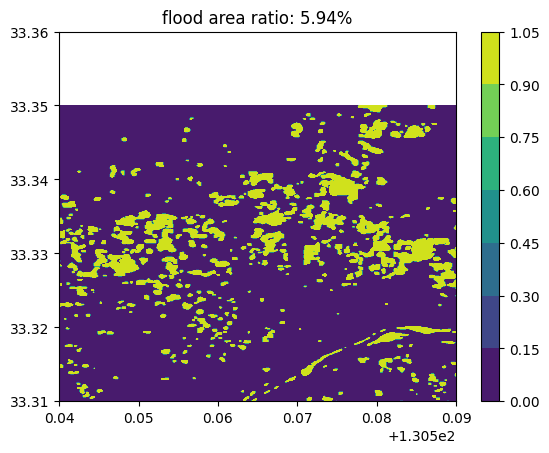

In [14]:
floodmap_red = reduce_specles(floodmap,patchsize=3, specle_threshold=0.3)
img = plt.contourf(lons,lats,floodmap_red)
plt.title(f"flood area ratio: {100 * np.sum(floodmap_red) / totalsize:1.2f}%")
plt.xlim([130.54, 130.59])
plt.ylim([33.31, 33.36])
plt.colorbar(img)

In [15]:
flood_pts = []
nx, ny = floodmap_red.shape
for ii in range(nx):
  for jj in range(ny):
    if floodmap_red[ii,jj] == 1:
      for pp in range(num_pt_px):
        idx_x = ii+np.random.rand()
        idx_y = jj+np.random.rand()
        lon, lat = gridIdx_to_lonlat(idx_x, idx_y,lons,lats)
        #print((idx_x, idx_y), " : ", (lon, lat))
        flood_pts.append({"lon":lon, "lat":lat})
print(len(flood_pts))
print(flood_pts[0:3])

1745177
[{'lon': 130.40020006671634, 'lat': 33.27200801343336}, {'lon': 130.40014877021386, 'lat': 33.27198702770918}, {'lon': 130.40016135635506, 'lat': 33.27200859006829}]


In [16]:
print(file_pts)

/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/kurume-r2/flood_points.pkl


In [17]:
with open(file_pts, "wb") as ofile:
  pickle.dump(flood_pts, ofile)